In [1]:

# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


In [2]:

# Load data
essays = pd.read_csv('train_essays.csv')


In [3]:

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d', ' ', text)
    
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Substitute multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Remove leading and trailing spaces
    text = text.strip()
    
    # Tokenize the text
    tokens = text.split()
    
    # Remove stopwords and stem the words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens if word not in stopwords.words('english')]
    
    return ' '.join(tokens)


In [4]:

# Preprocess data
essays['cleaned_text'] = essays['text'].apply(preprocess_text)


# Print the number of preprocessed texts
print(f"Number of preprocessed texts: {len(essays['cleaned_text'])}")

# Split constants and variable
X = essays[['id', 'prompt_id', 'cleaned_text']]
y = essays['generated']


Number of preprocessed texts: 1378


In [5]:

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['cleaned_text'])
X_test_vec = vectorizer.transform(X_test['cleaned_text'])

# Create an instance of classifier and train
model = RandomForestClassifier(n_estimators=100, random_state=42)
# model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Make predictions
predictions = model.predict(X_test_vec)


In [6]:

# Add predictions to X_test
X_test['predicted'] = predictions
X_test['actual'] = y_test

# Compare actual and predicted values
comparison = X_test[['id', 'actual', 'predicted']]
print(comparison)


            id  actual  predicted
216   2bf52db3       0          0
345   43f2fd5a       0          0
872   9d3a9a2c       0          0
1316  f404b91b       0          0
241   30181dbc       0          0
...        ...     ...        ...
441   575e5af1       0          0
1260  eaea47df       0          0
95    1539183b       0          0
1336  f7e59043       0          0
1335  f7aa848d       0          0

[276 rows x 3 columns]


In [7]:

# Get class probabilities
probabilities = model.predict_proba(X_test_vec)

# Add probabilities to X_test
X_test['prob_0'] = probabilities[:, 0]
X_test['prob_1'] = probabilities[:, 1]

# Threshold Analysis
threshold = 0.6
X_test['predicted_70'] = (X_test['prob_1'] > threshold).astype(int)

# Confidence Levels
X_test['confidence'] = X_test[['prob_0', 'prob_1']].max(axis=1)

# Misclassified Samples Analysis
X_test['correctly_classified'] = X_test['predicted'] == X_test['actual']


print(X_test)


            id  prompt_id                                       cleaned_text  \
216   2bf52db3          0  car use machin get around may realiz mani prob...   
345   43f2fd5a          1  lot discuss whether keep elector colleg electo...   
872   9d3a9a2c          0  car usual peopl everi day live drive work scho...   
1316  f404b91b          0  world live mani peopl use car get around like ...   
241   30181dbc          1  elector colleg way us unit state citizen vote ...   
...        ...        ...                                                ...   
441   575e5af1          1  lot disput elector colleg therefor caus much c...   
1260  eaea47df          0  citi vauban germani pari franc bogota colombia...   
95    1539183b          0  world live today car use peopl nearli everyday...   
1336  f7e59043          0  car everyday averag citizen use car get around...   
1335  f7aa848d          1  dear senat favor elector colleg elector colleg...   

      predicted  actual  prob_0  prob_1

In [8]:

# AUC - ROC curve
def plot_roc(y_true, y_score, label, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label} AUC = {roc_auc_score(y_true, y_score):.2f}")



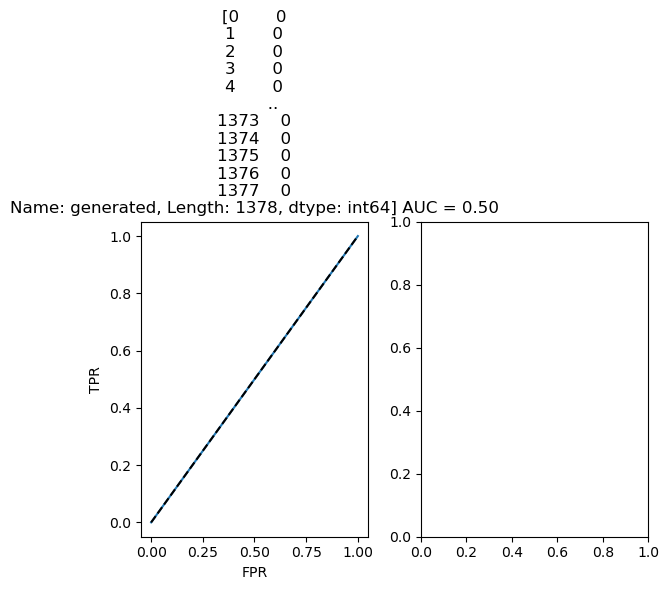

In [9]:

# auc-roc curve chart for training set
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

plot_roc(y_test, predictions, [y], ax=ax[0])

fig.tight_layout()
plt.show()


In [10]:

# Evaluate your model
print(f'Accuracy: {accuracy_score(y_test, predictions) * 100:.2f} %')


Accuracy: 99.64 %


In [12]:

# Load test essay
test_essays = pd.read_csv('test_essays.csv')

# Preprocess the text data in test_essays
test_essays['cleaned_text'] = test_essays['text'].apply(preprocess_text)

# Vectorize the cleaned_text in test_essays using the same vectorizer fitted on X_train
test_essays_vec = vectorizer.transform(test_essays['cleaned_text'])

# Make predictions
test_predictions = model.predict(test_essays_vec)

# Add predictions to test_essays
test_essays['predicted'] = test_predictions


In [13]:
print(test_essays)

         id  prompt_id          text cleaned_text  predicted
0  0000aaaa          2  Aaa bbb ccc.  aaa bbb ccc          0
1  1111bbbb          3  Bbb ccc ddd.  bbb ccc ddd          0
2  2222cccc          4  CCC ddd eee.  ccc ddd eee          0
